# <center> Исследование данных HR-агенства

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о заработной плате в области науки о данных (заработная плата в сфере Data Science).

Данные содержат следующие столбцы:
*   *work_year* — год, в котором была выплачена заработная плата;
*   *experience_level* — опыт работы на этой должности в течение года: EN — Entry-level/Junior, MI — Mid-level/Intermediate, SE — Senior-level/Expert, EX — Executive-level/Director;
*   *employment_type* — тип трудоустройства для этой роли: T — неполный рабочий день, FT — полный рабочий день, CT — контракт, FL — фриланс;
*   *job_title* — роль, в которой соискатель работал в течение года;
*   *salary* — общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *csalary_in_usd* — зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com.);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — 	Общий объём работы, выполняемой удалённо. Возможные значения: 0 — удалённой работы нет (менее 20 %), 50 — частично удалённая работа, 100 — полностью удалённая работа (более 80 %);
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166;
*   *company_size* — Среднее количество людей, работавших в компании в течение года: S — менее 50 сотрудников (небольшая компания), M — от 50 до 250 сотрудников (средняя компания), L — более 250 сотрудников (крупная компания).

Источник датасета: ["Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

## Загрузка данных

In [26]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей, без пропущенных значений.

In [5]:
# Проверяем данные на наличие дубликатов
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


Информативным признаком о заработной плате является столбец salary_in_usd, в котором заработная плата приведена для всех объектов в одной валюте, таким образом, признаки salary и salary_currency не несут полезной информации.

In [6]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

В представленном датасете числовым признаком является:
*   *salary_in_usd*

Остальные признаки можно отнести к категориальным. В том числе и признак work_year, так как данные представлены за 3 года (с 2020 до 2022), можно говорить о том, что данный признак имеет ограниченный набор значений, каждый объект данных принадлежит одному из трех годов. 

In [7]:
# Основные статистические характеристики для числового признака salary_in_usd
data['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Можно отметить, что размер минимальной и макисмальной заработной платы существенно отличается. Максимальная заработная плата больше минимальной в 209 раз.

In [8]:
# Основные статистические характеристики для признаков типа 'object'
data.describe(include=['object'])

,experience_level,employment_type,job_title,employee_residence,company_location,company_size
count,607,607,607,607,607,607
unique,4,4,50,57,50,3
top,SE,FT,Data Scientist,US,US,M
freq,280,588,143,332,355,326


Наиболее часто встречаются должности уровня Senior/Expert с полным рабочим днем и ролью Data Scientist. Самой популярной страной проживания сотрудника и страной главного офиса работодателя является США, а большинство компаний - средние с количеством сотрудников от 50 до 250.

## Разведывательный анализ данных

### Визуальный анализ данных

#### Размер заработной платы по годам.

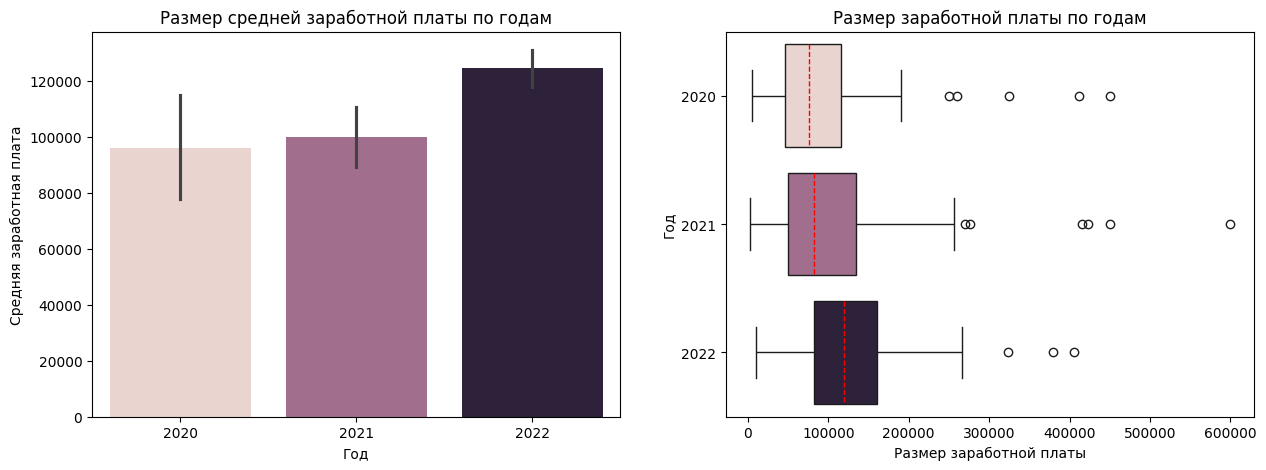

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по годам
sns.barplot(
            data, 
            x='work_year', 
            y='salary_in_usd', 
            hue='work_year', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по годам')

# Строим коробчатую диаграмму для визуализации размера заработной платы по годам
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='work_year', 
            orient='h', 
            hue='work_year',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Год')
axes[1].set_title('Размер заработной платы по годам')

plt.show()

In [15]:
salary_year = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработная плата по годам')
salary_year

Заработная плата по годам


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


Можно отметить, что размер средней заработной платы в 2020 и 2021 году отличается незначительно, а в 2022 году средняя заработная плата вырастает на 25%. Это может говорить об увеличении спроса на специалистов, что соответственно привело к росту уровня заработной платы. При этом, в 2022 году макисмальная заработная плата была самая низкая. Так же среди всех трех лет наблюдений в 2021 году отмечена как самая высокая так и самая низкая заработная плата.

Размер заработной платы по годам имеет различия. Чтобы определить, являются ли эти различия статистически значимыми, необходимо провести статистическое тестирование.

##### Размер заработной платы по годам у специалистов Data Scientist

In [12]:
# Фильтруем датасет, чтобы отобрать данные по специалистам Data Scientist
data_sc = data[data['job_title'] == 'Data Scientist']

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
7,7,2020,MI,FT,Data Scientist,35735,HU,50,HU,L
10,10,2020,EN,FT,Data Scientist,51321,FR,0,FR,S
11,11,2020,MI,FT,Data Scientist,40481,IN,0,IN,L
12,12,2020,EN,FT,Data Scientist,39916,FR,0,FR,M
...,...,...,...,...,...,...,...,...,...,...
592,592,2022,SE,FT,Data Scientist,230000,US,100,US,M
593,593,2022,SE,FT,Data Scientist,150000,US,100,US,M
596,596,2022,SE,FT,Data Scientist,210000,US,100,US,M
598,598,2022,MI,FT,Data Scientist,160000,US,100,US,M


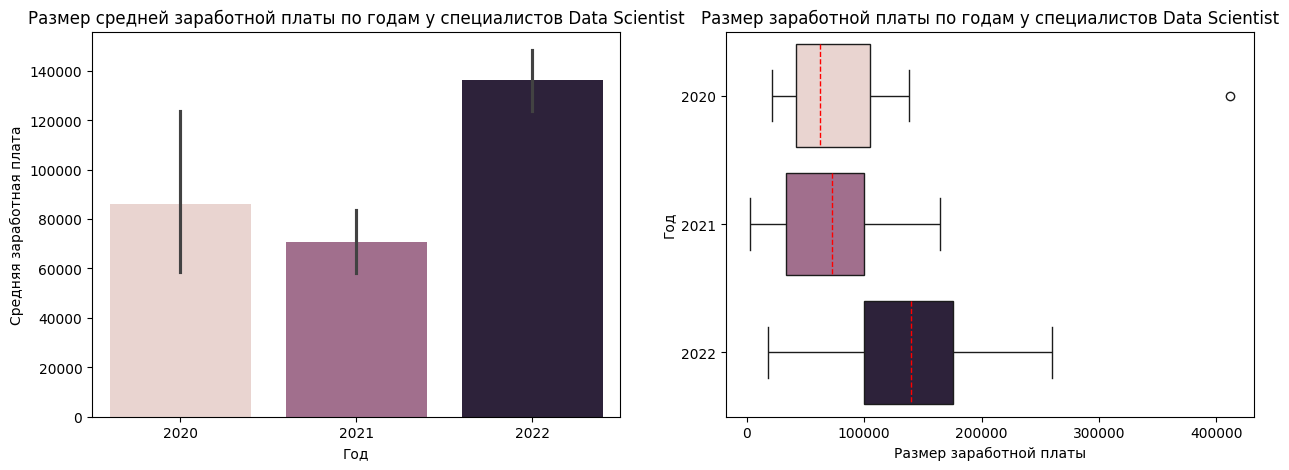

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по годам у специалистов Data Scientist
sns.barplot(
            data_sc, 
            x='work_year', 
            y='salary_in_usd', 
            hue='work_year', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Год', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по годам у специалистов Data Scientist')

# Строим коробчатую диаграмму для визуализации размера заработной платы по годам у специалистов Data Scientist
sns.boxplot(
            data_sc, 
            x='salary_in_usd', 
            y='work_year', 
            orient='h', 
            hue='work_year',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Год')
axes[1].set_title('Размер заработной платы по годам у специалистов Data Scientist')

plt.show()

In [16]:
salary_year = data_sc.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработная плата по годам у специалистов Data Scientist')
salary_year

Заработная плата по годам у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Если рассматривать показатели заработной платы специалистов Data Scientist, то они отличаются от общих показателей. Для всех специальностей средняя заработная плата ежегодна росла, тогда как у специалистов Data Scientist в 2021 году она упала по сравнению с 2020 на 18%, а максимальная сократилась более чем в 2 раза.  Затем, в 2022 году средняя заработная плата выросла почти в 2 раза, при этом максимальная заработная плата осталась ниже уровня 2020 года. Так же можно отметить, что минимальная заработная плата среди всех специальностей отмечена у специалиста Data Scientist. 

Если в данных по заработной плате среди всех специалистов присутствуют некоторое количество выбросов, то в данных о заработной плате специалистов Data Scientist наблюдается только один выброс в 2020 году.

#### Распределение опыта работы

In [35]:
# Получаем объект Series с распределением опыта работы среди всех сотруднков
data_experience = data['experience_level'].value_counts()

In [36]:
# Получаем объект Series с распределением опыта работы среди специалистов Data Scientist
data_sc_experience = data_sc['experience_level'].value_counts()

Text(0.5, 1.0, 'Распределение опыта работы среди специалистов Data Scientist')

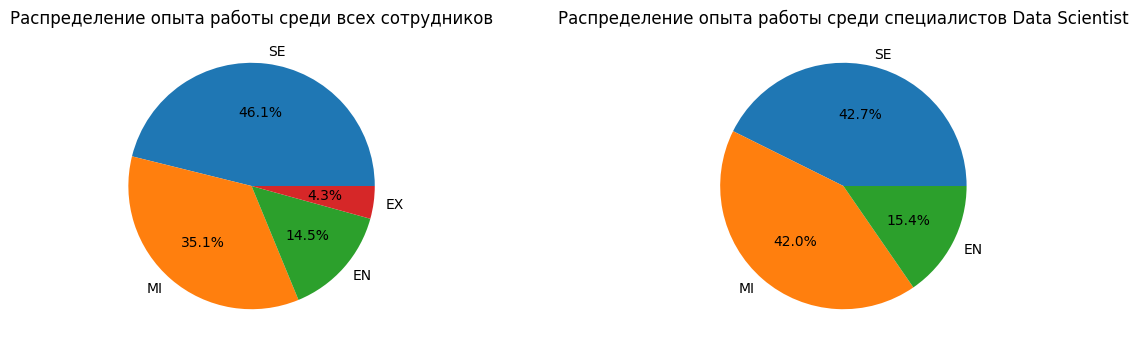

In [34]:
# Строим курговые диаграммы с рапределением опыта работы среди всех сотрудников и специалистов Data Scientist
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))
axes[0].pie(data_experience, labels = data_experience.index, autopct = '%.1f%%')
axes[0].set_title('Распределение опыта работы среди всех сотрудников')
axes[1].pie(data_sc_experience, labels = data_sc_experience.index, autopct = '%.1f%%')
axes[1].set_title('Распределение опыта работы среди специалистов Data Scientist')

Два наиболее часто встречающихся уровня должности в обеих выборках - Mid-level и Senior-level. Senior-level лидирует в обеих выборках. Но если в данных по всем сотрудникам разница между Mid-level и Senior-level есть и составляет 9%, то в выборке специалистов Data Scientist - оба уровня имеют одинаковый процент. На третьем месте идет уровень - Entry-level, он имеет близкий показатель в обеих выборках. Самый высокий уровень Executive-level представлен только в данных для всех специалистов и занимает всего 4%.

Можно сделать вывод, что наиболее востребованными как для всех специальностей, так и для специалистов Data Scientist являются сотрудники с опытом Mid-level и Senior-level. Уровень Entry-level занимает всего 15%, а значит конкуренция на такие места довольна высокая, как и для уровня  Executive-level. Однако можно предпродолжить, что специалистов с уровнем Executive-level в принципе намного меньше, чему с уровнем Entry-level. 

#### Соотношение заработной платы у сотрудников с разным опытом работы

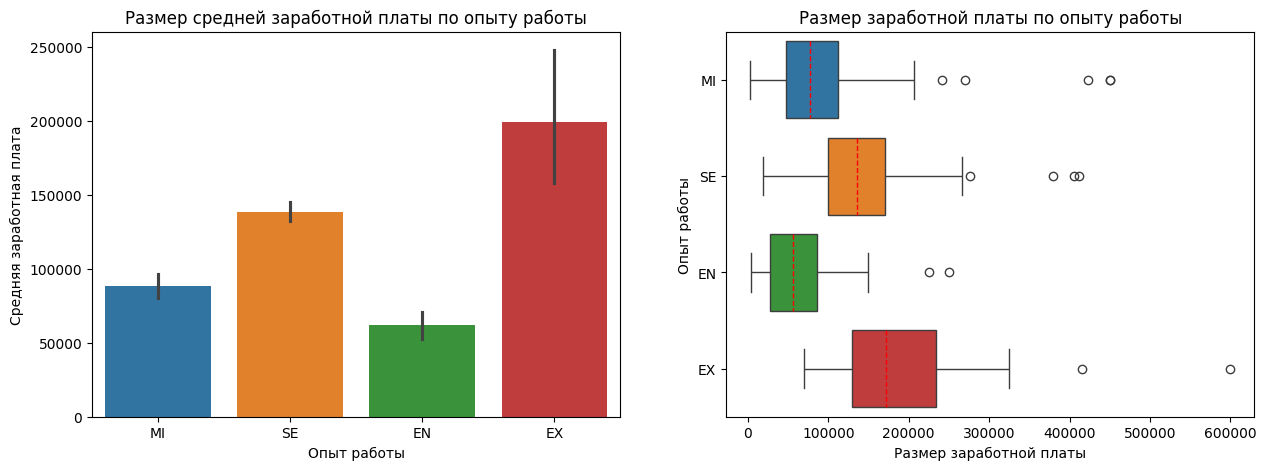

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по опыту работы
sns.barplot(
            data, 
            x='experience_level', 
            y='salary_in_usd', 
            hue='experience_level', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Опыт работы', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней заработной платы по опыту работы')

# Строим коробчатую диаграмму для визуализации размера заработной платы по опыту работы
sns.boxplot(
            data, 
            x='salary_in_usd', 
            y='experience_level', 
            orient='h', 
            hue='experience_level',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Опыт работы')
axes[1].set_title('Размер заработной платы по опыту работы')

plt.show()

In [51]:
salary_experience = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Заработная плата по опыту работы')
salary_experience

Заработная плата по опыту работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0


#### Соотношение заработной платы у специалистов Data Scientist с разным опытом работы

In [49]:
data_sc_sort = data_sc.sort_values(by = 'experience_level') 

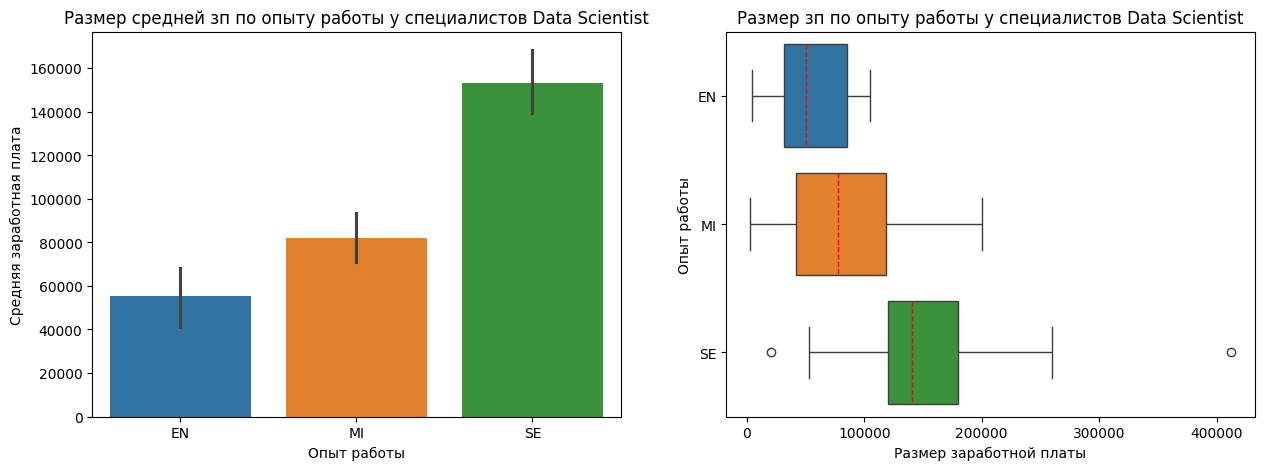

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Строим столбчатую диаграмму для визуализации размера средней заработной платы по опыту работы у специалистов Data Scientist
sns.barplot(
            data_sc_sort, 
            x='experience_level', 
            y='salary_in_usd', 
            hue='experience_level', 
            legend=False, 
            ax=axes[0]
            )
axes[0].set(xlabel='Опыт работы', ylabel='Средняя заработная плата')
axes[0].set_title('Размер средней зп по опыту работы у специалистов Data Scientist')

# Строим коробчатую диаграмму для визуализации размера заработной платы по опыту работы у специалистов Data Scientist
sns.boxplot(
            data_sc_sort, 
            x='salary_in_usd', 
            y='experience_level', 
            orient='h', 
            hue='experience_level',
            legend=False, 
            medianprops={"color": "red", "linestyle": '--'}
            )
axes[1].set(xlabel='Размер заработной платы', ylabel='Опыт работы')
axes[1].set_title('Размер зп по опыту работы у специалистов Data Scientist')

plt.show()

In [52]:
salary_experience_ds = data_sc_sort.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Заработная плата по опыту работы у специалистов Data Scientist')
salary_experience_ds

Заработная плата по опыту работы у специалистов Data Scientist


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Анализ сооношения заработной платы и опыта работы показал, что, чем больше опыт работы, тем выше заработная плата.

Если в данных по всем сотрудникам заработная плата растет постепенно с увеличением опыта работы, то у специалистов Data Scientist наблюдается резкий скачок уровня заработной платы между специалистами уровня Mid-level и Senior-level. По всем статистическим показателям разница в заработных платах этих двух уровней составляет 2 и более раз. Можно предположить, что специалисты Senior-level относятся к категории руководителей, соответственно к ним предъявляются более высокие требования, они решают более сложные и серьезные задачи, соответственно их работа оплачивается более высоко.

Если в данных по заработной плате среди всех специалистов присутствуют некоторое количество выбросов, то в данных о заработной плате специалистов Data Scientist наблюдается выбросы только для Senior-level.

#### Распределение заработной платы среди всех сотрудников

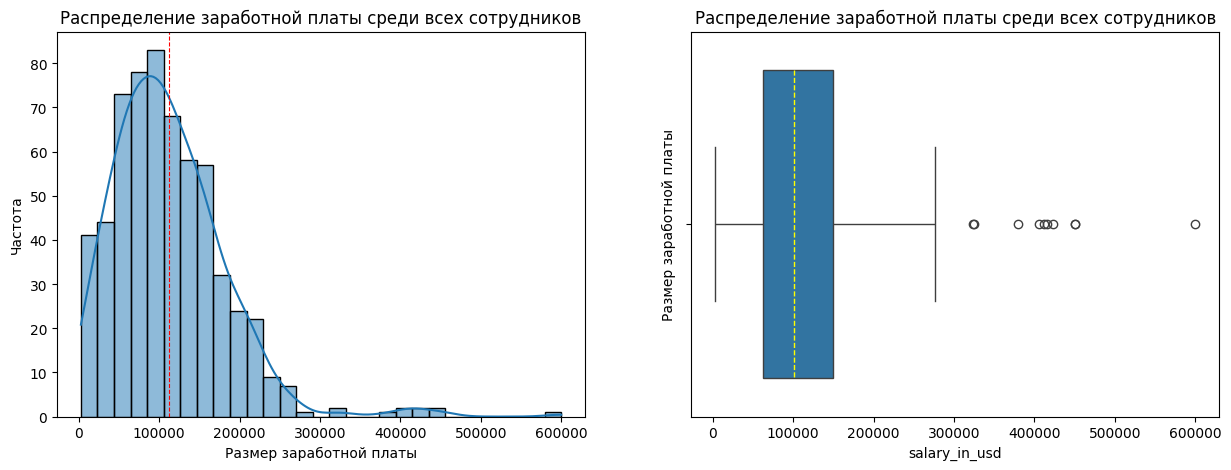

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы', ylabel='Частота')
axes[0].set_title('Распределение заработной платы среди всех сотрудников')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "yellow", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы среди всех сотрудников')

plt.show()

Распределение заработной платы отлично от нормального, имеются выбросы.

#### Соотношение зарплаты Data Scientist и Data Engineer в 2022 году